In [24]:
#Download the required libraries
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets, models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torch.onnx
import torchvision

%matplotlib inline

plt.ion()   # interactive moden

In [25]:
# i suppose what your image folders placed in datasets directory 
data_dir= "C:/Users/User/Rover-Trasher/"

# Data scaled and normalization for training and testing
norm = 1.5
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(32),
        transforms.ToTensor(),
        transforms.Normalize([norm, norm, norm], [norm, norm, norm])
    ]),
    'test': transforms.Compose([
        transforms.RandomResizedCrop(32),
        transforms.ToTensor(),
        transforms.Normalize([norm, norm, norm], [norm, norm, norm])
    ]),
}

#Create function to get your(my) images dataset and resize it to size for model
def get_dataset(data_dir, data_transforms ):


    # create train and test datasets
    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                              data_transforms[x])
                      for x in ['train', 'test']}
    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                                 shuffle=True, num_workers=4)
                  for x in ['train', 'test']}
    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
    #get classes from train dataset folders name
    classes = image_datasets['train'].classes

    return dataloaders["train"], dataloaders['test'], classes, dataset_sizes

In [26]:
# get train and test data
trainloader, testloader, classes, dataset_sizes = get_dataset(data_dir, data_transforms)
print('Classes: ',  classes)
print('The datasest have: ',  dataset_sizes ," images")

Classes:  ['nopaper', 'paper']
The datasest have:  {'train': 21, 'test': 4}  images


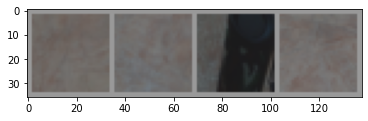

nopaper nopaper paper nopaper


In [27]:
# create function for print unnormalized images
def imshow(img):
    img = img / 2 + 0.6      # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)
#images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [28]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5 )
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)


In [29]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
device = torch.device("cuda")

In [30]:
for epoch in range(15):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        print(epoch, running_loss / 15)
        '''if i % 15 == 14:    # print every 15 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 15))
            running_loss = 0.0'''

print('Finished Training')

0 0.04622679154078166
0 0.09504806200663249
0 0.13999736309051514
0 0.18620668252309164
0 0.23114978075027465
0 0.27481602827707924
1 0.04625678062438965
1 0.09378410180409749
1 0.13996918201446534
1 0.18612815539042155
1 0.23101128737131754
1 0.27459927399953205
2 0.04480997323989868
2 0.09093043406804403
2 0.1384276827176412
2 0.18463470538457236
2 0.2307743231455485
2 0.27407028277715045
3 0.04613654216130574
3 0.09074845711390177
3 0.13687611023585003
3 0.1844883640607198
3 0.23058790763219197
3 0.2736077586809794
4 0.046029468377431236
4 0.09366203546524048
4 0.13809885581334433
4 0.18402174711227418
4 0.22998083829879762
4 0.27284005482991536
5 0.0462005893389384
5 0.09222244024276734
5 0.13810468117396038
5 0.18407037655512493
5 0.22996146281560262
5 0.2724684953689575
6 0.04418911933898926
6 0.08842194080352783
6 0.1360232392946879
6 0.18011173009872436
6 0.22774449189503987
6 0.2770253578821818
7 0.044036730130513506
7 0.08808849255243938
7 0.13377087116241454
7 0.181415204207

Predict class - nopaper, real class - nopaper, probability (nopaper,paper) - tensor([ 0.0683, -0.0002])
Predict class - nopaper, real class - nopaper, probability (nopaper,paper) - tensor([0.0624, 0.0081])
Predict class - paper, real class - paper, probability (nopaper,paper) - tensor([0.0243, 0.1279])
Predict class - paper, real class - paper, probability (nopaper,paper) - tensor([0.0307, 0.0841])


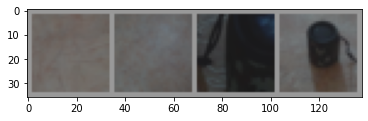

GroundTruth:  nopaper nopaper paper paper


In [31]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        
        for printdata in list(zip(predicted,labels,outputs)):
            printclass =[classes[int(printdata[0])],classes[int(printdata[1])]]
            print('Predict class - {0}, real class - {1}, probability ({2},{3}) - {4}'.format( printclass[0],printclass[1],
                                                                              classes[0], classes [1],printdata[2]))

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        imshow(torchvision.utils.make_grid(images))
        print('GroundTruth: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

In [32]:
torch.save(net.state_dict(), "models/model1.pth")

Predict class - paper, real class - paper, probability (nopaper,paper) - tensor([0.0359, 0.0831])
Predict class - nopaper, real class - nopaper, probability (nopaper,paper) - tensor([0.0629, 0.0077])
Predict class - paper, real class - paper, probability (nopaper,paper) - tensor([0.0240, 0.1274])
Predict class - nopaper, real class - nopaper, probability (nopaper,paper) - tensor([ 0.0684, -0.0019])


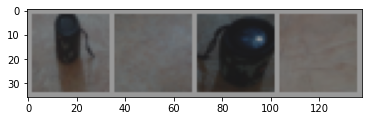

Accuracy of the network on the 4 test images: 100 %


In [33]:
net = Net()
net.load_state_dict(torch.load('models/model1.pth'))

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        
        for printdata in list(zip(predicted,labels,outputs)):
            printclass =[classes[int(printdata[0])],classes[int(printdata[1])]]
            print('Predict class - {0}, real class - {1}, probability ({2},{3}) - {4}'.format( printclass[0],printclass[1],
                                                                              classes[0], classes [1],printdata[2]))

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        imshow(torchvision.utils.make_grid(images))
        #print('GroundTruth: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))
print('Accuracy of the network on the', dataset_sizes['test'], 'test images: %d %%' % (
    100 * correct / total))

In [34]:
PATH = "models/model.onnx"
dummy_input = Variable(torch.randn(1, 3, 32, 32))
torch.onnx.export(net, dummy_input, PATH)